# Actividad 6 de reforzamiento: utilización de modelos de redes neuronales 


In [11]:
%pip install tensorflow plotly numpy tqdm opencv-python matplotlib scikit-learn keras imutils

import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import plotly.offline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.applications.vgg16 import preprocess_input
from keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

plotly.offline.init_notebook_mode(connected=True)

RANDOM_SEED = 123
print("ok")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\ismae\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


ok


La ruta existe.

Distribuyendo imágenes...

Clase: YES, Imágenes encontradas: 155
Copiado: ./brain_tumor_dataset/yes\Y1.jpg -> TEST\YES\Y1.jpg
Copiado: ./brain_tumor_dataset/yes\Y10.jpg -> TEST\YES\Y10.jpg
Copiado: ./brain_tumor_dataset/yes\Y100.JPG -> TEST\YES\Y100.JPG
Copiado: ./brain_tumor_dataset/yes\Y101.jpg -> TEST\YES\Y101.jpg
Copiado: ./brain_tumor_dataset/yes\Y102.jpg -> TEST\YES\Y102.jpg
Copiado: ./brain_tumor_dataset/yes\Y103.jpg -> TRAIN\YES\Y103.jpg
Copiado: ./brain_tumor_dataset/yes\Y104.jpg -> TRAIN\YES\Y104.jpg
Copiado: ./brain_tumor_dataset/yes\Y105.jpg -> TRAIN\YES\Y105.jpg
Copiado: ./brain_tumor_dataset/yes\Y106.jpg -> TRAIN\YES\Y106.jpg
Copiado: ./brain_tumor_dataset/yes\Y107.jpg -> TRAIN\YES\Y107.jpg
Copiado: ./brain_tumor_dataset/yes\Y108.jpg -> TRAIN\YES\Y108.jpg
Copiado: ./brain_tumor_dataset/yes\Y109.JPG -> TRAIN\YES\Y109.JPG
Copiado: ./brain_tumor_dataset/yes\Y11.jpg -> TRAIN\YES\Y11.jpg
Copiado: ./brain_tumor_dataset/yes\Y111.JPG -> TRAIN\YES\Y111.JPG
Copiado

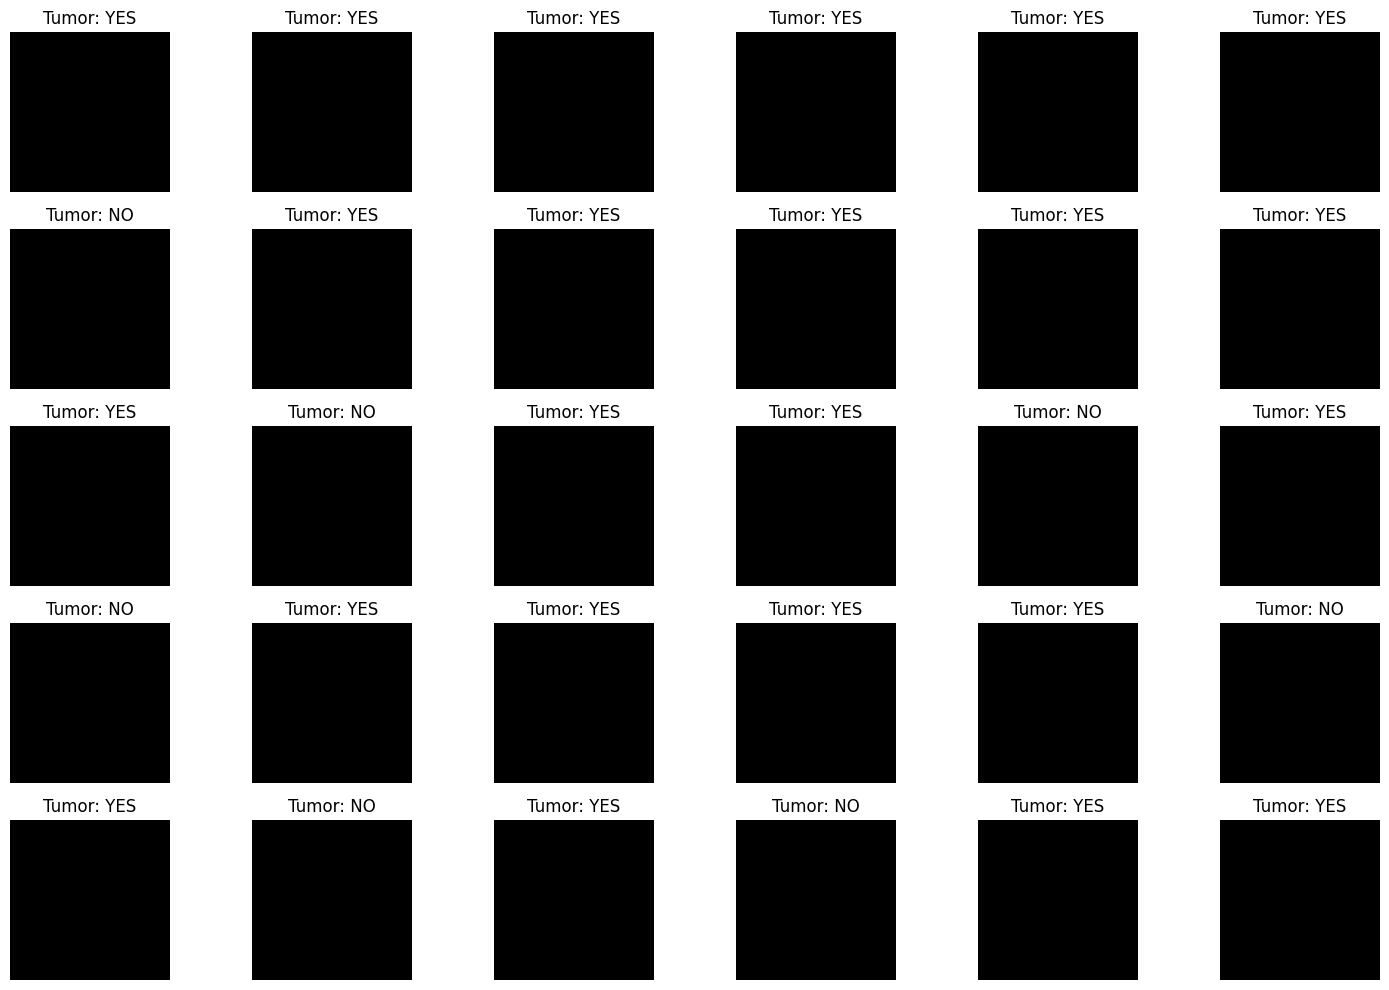

In [ ]:
IMG_PATH = "./brain_tumor_dataset/"

if os.path.exists(IMG_PATH):
    print("La ruta existe.")
else:
    print("La ruta NO existe.")

for split in ["TRAIN", "TEST", "VAL"]:
    for class_name in ["YES", "NO"]:
        os.makedirs(os.path.join(split, class_name), exist_ok=True)

for CLASS in ["yes", "no"]:
    class_path = os.path.join(IMG_PATH, CLASS)
    if os.path.exists(class_path):
        IMG_NUM = len(os.listdir(class_path))
        print(f"\nClase: {CLASS.upper()}, Imágenes encontradas: {IMG_NUM}")
        
        for n, FILE_NAME in enumerate(os.listdir(class_path)):
            src = os.path.join(class_path, FILE_NAME)
            
            if n < 5:
                dest_dir = "TEST"
            elif n < int(0.8 * IMG_NUM):
                dest_dir = "TRAIN"
            else:
                dest_dir = "VAL"
            
            dest = os.path.join(dest_dir, CLASS.upper(), FILE_NAME)
            shutil.copy(src, dest)
            print(f"Copiado: {src} -> {dest}")

def load_data(directory, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
                images.append(img)
                labels.append(0 if class_name == "NO" else 1)
            except Exception as e:
                print(f"Error cargando {img_path}: {str(e)}")
    
    return np.array(images), np.array(labels), class_names

dirs = {
    "TRAIN": "TRAIN",
    "TEST": "TEST",
    "VAL": "VAL"
}
IMG_SIZE = (224, 224) 

X_train, y_train, labels = load_data(dirs["TRAIN"], IMG_SIZE)
X_test, y_test, _ = load_data(dirs["TEST"], IMG_SIZE)
X_val, y_val, _ = load_data(dirs["VAL"], IMG_SIZE)

print(f"\nDatos cargados:")
print(f"Entrenamiento: {len(X_train)} imágenes")
print(f"Prueba: {len(X_test)} imágenes")
print(f"Validación: {len(X_val)} imágenes")

def plot_samples(images, labels, class_names, n_samples=30):
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)
    
    splabels = {
        0: "Tumor: NO",
        1: "Tumor: YES"
}

    for i, idx in enumerate(indices):
        plt.subplot(5, 6, i+1)
        plt.imshow(images[idx].astype('uint8'))
        plt.title(splabels[labels[idx]])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nMostrando muestras de entrenamiento...")
X_train_normalized = X_train.astype('float32') / 255.0

print(f"\nTamaño de las imágenes:")
print(f"Ejemplo X_train: {X_train_normalized[0].shape}")  

plot_samples(X_train_normalized, y_train, ["NO", "YES"]) 

# Preparación del Generador de Imágenes con Augmentación
Usamos el ImageDataGenerator para aplicar augmentación de datos (rotación, desplazamientos, volteos) y normalización para el modelo VGG16.

In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

# Construcción y Compilación del Modelo VGG16
Cargamos el modelo preentrenado VGG16 sin las capas superiores y añadimos nuestras propias capas para la clasificación binaria.

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    layers.Flatten(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Entrenamiento del Modelo
Entrenamos el modelo usando EarlyStopping para evitar el sobreajuste y realizar un seguimiento de la precisión y la pérdida.

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6)

history = model.fit(
    datagen.flow(X_train_normalized, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping]
)

C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5314 - loss: 1.2714 - val_accuracy: 0.6275 - val_loss: 2.8475
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4967 - loss: 1.1985 - val_accuracy: 0.6275 - val_loss: 2.8948
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4969 - loss: 1.1326 - val_accuracy: 0.6275 - val_loss: 2.9073
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5189 - loss: 1.1597 - val_accuracy: 0.6275 - val_loss: 2.8521
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5179 - loss: 1.0999 - val_accuracy: 0.6275 - val_loss: 3.0259
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5145 - loss: 1.0346 - val_accuracy: 0.6275 - val_loss: 3.0564
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5225 - loss: 1.1262 - val_accuracy: 0.6275 - val_loss: 3.2279


# Visualización de las Gráficas de Precisión y Pérdida
Aquí visualizamos cómo ha evolucionado la precisión y la pérdida durante el entrenamiento.

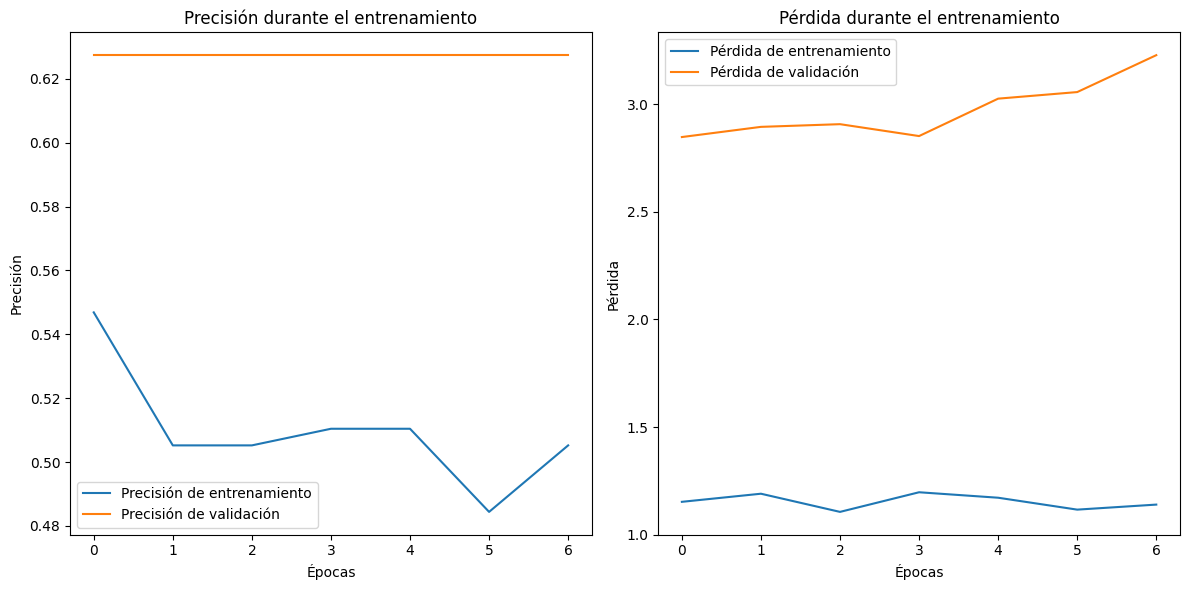

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

#  Evaluación del Modelo
Finalmente, evaluamos el modelo utilizando el conjunto de datos de prueba y mostramos la matriz de confusión y el reporte de clasificación.

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\n[MATRIZ DE CONFUSIÓN]")
print(cm)

# Reporte de clasificación
print("\n[REPORTE DE CLASIFICACIÓN]")
print(classification_report(y_test, y_pred, target_names=["Tumor: NO", "Tumor: YES"]))

# Para uardar el modelo si supera el 80% de precisión en la validación
val_accuracy = history.history['val_accuracy'][-1]
if val_accuracy > 0.8:
    model.save("brain_tumor_model.h5")
    print("\n¡Modelo guardado con éxito!")
else:
    print("\nEl modelo no alcanzó el umbral de 80% de precisión.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step

[MATRIZ DE CONFUSIÓN]
[[2 3]
 [2 3]]

[REPORTE DE CLASIFICACIÓN]
              precision    recall  f1-score   support

   Tumor: NO       0.50      0.40      0.44         5
  Tumor: YES       0.50      0.60      0.55         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10


El modelo no alcanzó el umbral de 80% de precisión.


Tengo que mejorar esto porque es un cara o cruz la verdad
